# Checking conservation of fluorescence

Loading BokehJS ...


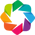

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import bokeh.plotting
import bokeh.io
import holoviews as hv
import mscl_utils as mscl
import mscl_mcmc as msmc
import tqdm
import skimage.io
import scipy.signal
import skimage.segmentation
import skimage.morphology
import theano.tensor as tt
import pymc3 as pm
import glob

# Use MATLAB python API to read in files. 
import matlab.engine as matlab
try:
    eng = matlab.connect_matlab()
except:
    eng = matlab.start_matlab()
bokeh.io.output_notebook()
hv.extension('bokeh')
# Define the root directory for the experiment.
root_dir = '../data/images/20171026_sfGFP_10ngmL_dilution/'

The purpose of this notebook is to analyze a dilution growth movie in which fluorescence and phase contrast images were taken repeatedly through several rounds of cell division. To ensure that the system is working as expected, I will perform several check such as volume effects, fluorescence conservation, and photobleaching. 

## Measuring the photobleaching rate constant 

In [2]:
# Load the brightfield images for each. 
delta_bf_im = skimage.io.imread(glob.glob('{0}delta_bleach/*Brightfield*.tif'.format(root_dir))[0])
auto_bf_im = skimage.io.imread(glob.glob('{0}auto_bleach/*Brightfield*.tif'.format(root_dir))[0])


# Flatten the image.
def im_to_float(im): 
    im_float = (im - im.min()) / (im.max() - im.min())
    im_blur = skimage.filters.gaussian(im_float, sigma=5)
    im_sub = im_float - im_blur
    return im_sub

def otsu_thresh(im):
    im_sub = im_to_float(im)
    thresh = skimage.filters.threshold_otsu(im_sub)
    seg = skimage.segmentation.clear_border(im_sub < thresh)
    seg = skimage.morphology.remove_small_objects(seg)
    mask = skimage.measure.label(seg)
    return mask

auto_seg = otsu_thresh(auto_bf_im)
delta_seg = otsu_thresh(delta_bf_im)


# Show the segmentation over the original image. 
delta_contours = skimage.measure.find_contours(delta_seg, 0)
auto_contours = skimage.measure.find_contours(auto_seg, 0)

p1 = mscl.bokeh_imshow(np.rot90(delta_bf_im), plot_height=400)
p2 = mscl.bokeh_imshow(np.rot90(auto_bf_im), plot_height=400)
for c in delta_contours:
    p1.line(c[:,0], c[:,1], color='tomato', line_width=2)
    
for c in auto_contours:
    p2.line(c[:,0], c[:,1], color='tomato', line_width=2)   
p1.title.text = 'constitutive'
p2.title.text = 'autofluorescence'
layout = bokeh.layouts.gridplot([[p1, p2]])
bokeh.io.show(layout)

Now with a segmentation mask in place, I can measure the fluorescence information for each cell over the entire time course.

In [3]:
# Load all of the images.
field_ims = skimage.io.ImageCollection('{0}*fluorescent_slide/Pos*/*.tif'.format(root_dir))
field_avg = mscl.average_stack(field_ims)
# instantiate the bleaching dataframe.
bleach_df = pd.DataFrame([], columns=['sample', 'cell_label', 'frame_number', 'total_intensity'])


sample_id = ['delta', 'auto']
seg_id= {'delta': delta_seg, 'auto': auto_seg}
for s in sample_id:
    bleach = np.sort(glob.glob('{0}{1}_bleach/*GFP*.tif'.format(root_dir, s))) 
    for i in tqdm.tqdm(range(len(bleach)), ascii=True):
        f = skimage.io.imread(bleach[i])
        flat = mscl.generate_flatfield(f, field_avg, median_filt=False)
        # Compute the properties. 
        props = skimage.measure.regionprops(seg_id[s], flat)
        for prop in props:
            cell_dict = {'sample': s}
            cell_dict['cell_label'] = prop.label
            cell_dict['total_intensity'] = prop.mean_intensity * prop.area
            cell_dict['frame_number'] = i 
        
            # Make a data frame.
            bleach_df = bleach_df.append(cell_dict, ignore_index=True)

100%|##########| 345/345 [01:03<00:00,  5.46it/s]


In [181]:
bleach_df.to_csv('../data/csv/20171027_bleaching_data.csv')

In [4]:
p1= mscl.bokeh_boiler(x_axis_label='frame number',
                     y_axis_label='relative intensity', 
                     title='autofluorescence', width=500, height=500)
p2 = mscl.bokeh_boiler(x_axis_label='frame number',
                     y_axis_label='relative intensity',
                      title='constitutive expression', width=500, height=500)

grouped = bleach_df.groupby(['sample', 'cell_label'])
axes = {'auto': p1, 'delta': p2}
for g, d in grouped:
    # Normalize each trace to the first 3 measurements.
    I_0 = d.iloc[5]['total_intensity'].mean()
    I_t = d['total_intensity'] 
    axes[g[0]].line(d['frame_number'], I_t, color='slategray', alpha=0.3, 
          hover_line_color='tomato', line_width=0.25)
    
layout = bokeh.layouts.gridplot([[p1, p2]])
bokeh.io.show(layout)

In [102]:
# look at just one trace.
single_cell = bleach_df.loc[(bleach_df['cell_label']== 5) & (bleach_df['sample']=='delta')]
I_0 = single_cell.iloc[0]['total_intensity']
I_t = single_cell['total_intensity'] 
# Smooth via savgol filtering. 
window = 51 
polyorder = 3
smoothed = scipy.signal.savgol_filter(I_t, window, polyorder)

# Show both.
p = mscl.bokeh_boiler(width=600, height=500)
p.circle(single_cell['frame_number'], I_t / I_0, color='slategray',
        legend='raw data', size=2)
p.line(single_cell['frame_number'], I_t / I_0, color='slategray',
      line_width=0.75)


# Plot the smoothed case.
p.line(single_cell['frame_number'], smoothed / I_0, color='dodgerblue', line_width=2,
      legend='SG Filter (order = {0}, window = {1})'.format(polyorder, window))
bokeh.io.show(p)

In [162]:
class MarginalizedNormal(pm.Continuous):
    """
    A bivariate Normal distribution after marginalization of sigma.

    g(µ, k| y) = ((y - μ)^2)^(-k/2)

    Parameters
    ----------
    mu : PyMC3 RV object
        The mean of the components of the distribution.

    """

    def __init__(self, mu=None, *args, **kwargs):
        super(MarginalizedNormal, self).__init__(*args, **kwargs)
        self.mu = mu = pm.theanof.floatX(tt.as_tensor_variable(mu))        


    def logp(self, value):
        k = value.shape[-1]
        mu = self.mu
        return -0.5 * k * tt.log(tt.sum((value - mu)**2))

    

class Jeffreys(pm.Continuous):
    """
    Jeffreys prior for a scale parameter.
    Parameters
    ----------
    lower : float, > 0
        Minimum value the variable can take.
    upper : float, > `lower`
        Maximum value the variable can take.
    Returns
    -------
    output : pymc3 distribution
        Distribution for Jeffreys prior.

    Notes
    -----
    This class was adopted from Justin Bois
    github.com/justinbois/bebi103
    """

    def __init__(self, lower=None, upper=None, transform='interval',
                 *args, **kwargs):
        # Check inputs
        if lower is None or upper is None:
            raise RuntimeError('`lower` and `upper` must be provided.')

        if transform == 'interval':
            transform = pm.distributions.transforms.interval(lower, upper)
        super(Jeffreys, self).__init__(transform=transform, *args, **kwargs)
        self.lower = lower = pm.theanof.floatX(tt.as_tensor_variable(lower))
        self.upper = upper = pm.theanof.floatX(tt.as_tensor_variable(upper))

        self.mean = (upper - lower) / tt.log(upper / lower)
        self.median = tt.sqrt(lower * upper)
        self.mode = lower

    def logp(self, value):
        lower = self.lower
        upper = self.upper
        return pm.distributions.dist_math.bound(
            -tt.log(tt.log(upper / lower)) - tt.log(value),
            value >= lower, value <= upper)


In [108]:
with pm.Model() as model:
    # Define the hyper priors   
    beta = pm.Normal('beta', mu=1E4, sd=1E3)
    BoundedNormal = pm.Bound(pm.Normal, lower=0)
    I0 = BoundedNormal('I0', mu=1E4, sd=1E3)
    tau = pm.HalfNormal('tau', sd=100)
    
    # Define the conditional priors.
    time = single_cell['frame_number'].values.astype(float)
    theo = beta + I0 * tt.exp(-time / tau)
    
    like = MarginalizedNormal('like', mu=theo,
                              observed=smoothed)
    trace = pm.sample(draws=5000, tune=5000, njobs=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10000/10000 [00:23<00:00, 425.60it/s]


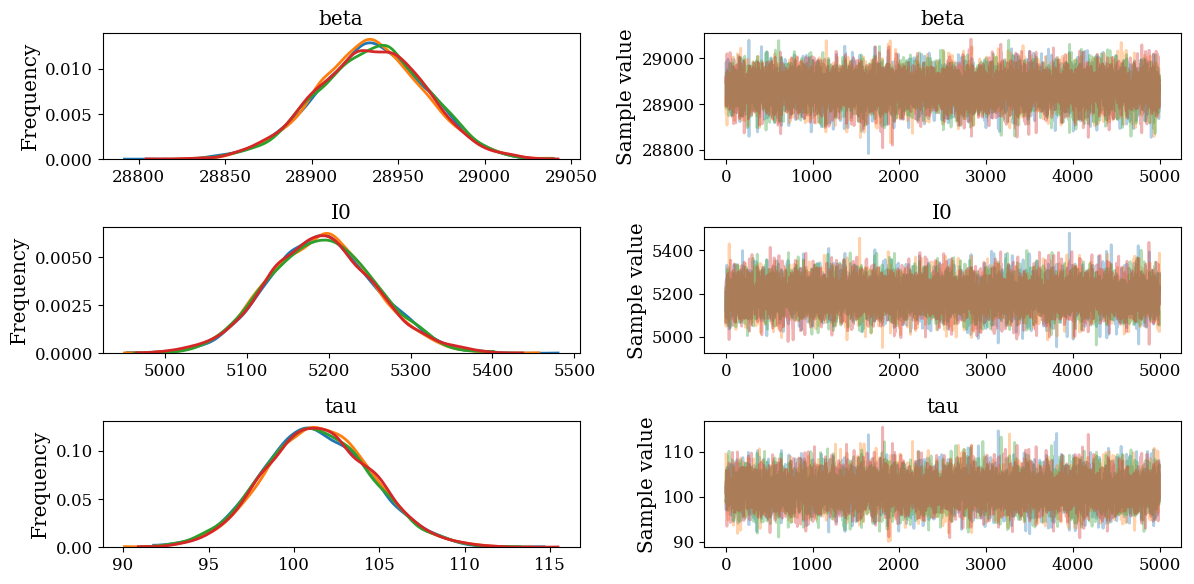

In [109]:
%matplotlib inline
_ = pm.traceplot(trace)

In [110]:
pm.gelman_rubin(trace)

{'I0': 1.0001371513786612,
 'beta': 1.0000976431020514,
 'tau': 1.0003042672023403}

In [111]:
mcmc_df = pm.trace_to_dataframe(trace)
mcmc_df['logp'] = pm.stats._log_post_trace(trace, model).sum(axis=1)
ind = np.argmax(mcmc_df['logp'])
modes = mcmc_df.iloc[ind]

In [112]:
frames = np.linspace(1, 600, 5000)
theo = modes['beta'] + modes['I0'] * np.exp(-frames / modes['tau'])
p = mscl.bokeh_boiler()
p.circle(single_cell['frame_number'], single_cell['total_intensity'], color='slategray', legend='raw_data')
p.line(single_cell['frame_number'], smoothed, color='tomato', 
       line_width=3, legend='smoothed_data')
p.line(frames, theo, color='dodgerblue', legend='fit with τ = {0:.2f} frames.'.format(modes['tau']),
       
      line_width=3)
bokeh.io.show(p)

### A heirarchical model for $\tau$

In [133]:
# Munging the dataframe.
delta = bleach_df.loc[bleach_df['sample']=='delta'].copy()
cell_ids = delta['cell_label'].values
frames = delta['frame_number'].values



In [178]:
# Look at only the delta strains first.
delta = bleach_df.loc[bleach_df['sample']=='delta']

# Set up the model.
with pm.Model() as model:
    # Define the hyper priors.
    mu_tau = pm.Uniform('mu_tau', lower=1E-3, upper=1E6)
    sig_tau = pm.HalfNormal('sig_tau', sd=100) 
    
    # Define the low level priors
    n_cells = len(delta['cell_label'].unique())
    beta = pm.Normal('beta', mu=1E4, sd=1E3, shape=n_cells)
    I0 = pm.Uniform('I0', lower=0, upper=1E6, shape=n_cells)
    tau = pm.Normal('tau', mu=mu_tau, sd=sig_tau, shape=n_cells)
    
    # Sort, the data by cell label.
    obs = delta['total_intensity'].values.astype(float)
    time = delta['frame_number'].values.astype(float)
    IDs = delta['cell_label'].values.astype(int) - 1
    
    # Compute the exptected value
    a = beta[IDs]
    b = I0[IDs]

    theo = beta[IDs] + I0[IDs] * tt.exp(-time / tau[IDs])
    
    # Define the likelihood.
    like = MarginalizedNormal('like', mu=theo, observed=obs)
    
    # Sample.
    trace = pm.sample(draws=200, tune=200, njobs=4) 

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
 44%|████▍     | 175/400 [00:01<00:01, 163.33it/s]/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 3 contains only 200 samples.
  % (self._chain_id, n))
/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.979297619048, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 3 contains 21 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 92%|█████████▏| 369/400 [06:34<00:33,  1.07s/it] /Us

## Measuring the mean autofluorescence 

In [673]:
# Load the images.
auto_bf_f = np.sort(glob.glob('{0}*auto_snaps/Pos*/*Brightfield*.tif'.format(root_dir)))
auto_bf_im = skimage.io.ImageCollection(auto_bf_f)
auto_gfp_f  = np.sort(glob.glob('{0}*auto_snaps/Pos*/*GFP*.tif'.format(root_dir)))
auto_gfp_im = skimage.io.ImageCollection(auto_gfp_f)

# Segment via Otsu.
auto_df = pd.DataFrame([], columns=['total_fluorescence', 'area'])
for bf, gfp in zip(auto_bf_im, auto_gfp_im):
    # Segment
    mask = otsu_thresh(bf)
    flat = mscl.generate_flatfield(gfp, field_avg)
    
    props = skimage.measure.regionprops(mask, flat)
    cell_dict = {}
    for prop in props:
        cell_dict['area'] = prop.area * 0.16**2
        cell_dict['total_fluorescence'] = prop.mean_intensity * prop.area 
        auto_df = auto_df.append(cell_dict, ignore_index=True)

In [678]:
mean_auto = np.mean(auto_df['total_fluorescence'])
mean_auto

97027.39460514099

## Parsing SuperSegger `cell.mat` fies

In [664]:
def cell_to_dict(file, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest. 
    
    The returned properties are 
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.
    
    
    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be 
        exactly how they are defined in the cell file.
    
    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files. 
    """
    
    # Ensure the supplied file is actually a .mat and other types are correct. 
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError("add_props is {0} and not dict.".format(type(add_props)))                  
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError("add_props must be list. Type is currently {0}.".format(type(excluded_props)))
                        
    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID', 
             'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo'] 
    
    # Load the mat file using MATLAB.
    mat = scipy.io.loadmat(file, squeeze_me=True,
                      chars_as_strings=True,
                      struct_as_record=True)
    
    # Assemble the dictionary for constant properties. 
    cell_dict = {v: mat[v] for v in vals[:-4]}
    daughters = mat['daughterID']
    
    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters 
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2
     
    # Extract fluorescence information -- This is a bit gross but checked.
    try:
        fluo = [mat['CellA'][i]['fl1'].flatten()[0].flatten()[0][0] for i, _ in enumerate(mat['CellA'])]
        nonzero = [f for f in fluo if f != 0] 
        num_exposures = len(nonzero)
        cell_dict['birth_fluo'] = nonzero[0] 
        cell_dict['death_fluo'] = nonzero[-1]
    except:
        cell_dict['birth_fluo'] = 0
        cell_dict['death_fluo'] = 0
        num_exposures = 0 
    cell_dict['num_exposures'] = num_exposures
    # Deal with exclusion and addition of props. 
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys(): 
            cell_dict[key] = add_props[key]
                        
    # Return the cell dictionary.
    return cell_dict

def parse_cell_files(files, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, **kwargs)  
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df            

Compute the autofluorescence distribution

In [682]:
# Restrict area to reasonable bounds.
cells = auto_df.loc[auto_df['area'] < 4]
mean_auto = cells['total_fluorescence'].mean()
mean_auto

85376.00295215128

Parse all position files 

In [137]:
# Assemble the entire DataFrame.
data_dir = '{0}growth/xy*'.format(root_dir)

# Grab all of the positions.
positions = glob.glob(data_dir)

# Loop through each position and generate the DataFrame.
for i, pos in enumerate(positions):
    # Figure out the position number.
    num = int(pos.split('xy')[-1])
    
    # Grab all of the files.
    files = glob.glob('{0}/cell/*.mat'.format(pos))
    
    # Generate the DataFrame.
    _df = parse_cell_files(files, add_props={'position': num})
    if i == 0:
        df = _df
    else:
        df = df.append(_df, ignore_index=True) 

In [139]:
# Restrict data frame to only those that divided or died on last frame. 
producers = df[(df['divide'] == 1) | (df['death']==37)].copy()

# Remove anomolous zeros.
measured = producers.loc[(producers['birth_fluo'] > 0) & (producers['death_fluo'] > 0)]

Group by the mother ID's  and position and look at the conservation of fluorescence. 

In [683]:
grouped = measured.groupby(['position', 'motherID'])
# Iterate through and compute the total fluorescence and mother fluorescence.

summed = []
mother = []
for g, d in grouped:
    mother_fluo = (measured[(measured['ID']==g[1]) & (measured['position']==g[0])]['death_fluo'] - mean_auto).sum()
    if mother_fluo != 0:
        mother.append(mother_fluo)
        summed.append(np.sum(d['birth_fluo']) - mean_auto)

In [782]:
# compute the expected linear trend.
theo = np.linspace(np.min(mother), np.max(mother), 300)
p = mscl.bokeh_boiler()
p.circle(mother, summed, color='slategray', alpha=0.5, legend='data',
        size=1)
p.line(theo, theo, color='dodgerblue', line_width=2, legend='conserved fluorescence')
bokeh.io.show(p)

## Measuring the fluctuations. 

In [697]:
dilution_df = pd.DataFrame([], columns=['sum_total', 'sq_diff'])
for g, d in grouped:
    if len(d) == 2:
        sum_total = (d['death_fluo'] - mean_auto).sum()
        sum_total = measured.loc[(measured['ID']==g[1]) & (measured['position']==g[0])]['death_fluo'].values.sum()
        sq_diff = (np.diff(d['birth_fluo'] - mean_auto)**2)[0]
        dilution_df = dilution_df.append(dict(sum_total=sum_total,
                                             sq_diff=sq_diff), ignore_index=True)

In [754]:
# Bin the data to compute the means. 
bin_width = 2 
bins = np.arange(0, len(dilution_df) + bin_width, bin_width)
sum_total_means, sq_diff_means = [], []
dilution_df.sort_values(by=['sum_total'], inplace=True)
for i in range(1, len(bins)):
    slc = dilution_df.iloc[bins[i-1]: bins[i] + 1]
    sum_total_means.append(slc['sum_total'].mean())
    sq_diff_means.append(slc['sq_diff'].mean())
 

def lin_reg(x, alpha):
    return alpha * x

popt, junk = scipy.optimize.curve_fit(lin_reg, sum_total_means, sq_diff_means)

# Plot the raw data and the computed means.
p = mscl.bokeh_boiler(x_axis_type='log', y_axis_type='log',
                     x_axis_label='I\u2081 + I\u2082',
                     y_axis_label='(I\u2081 + I\u2082)\u00B2',
                     width=600, height=450)
p.circle(dilution_df['sum_total'], dilution_df['sq_diff'], 
         color='slategray', alpha=0.5, size=2, legend='data')
p.circle(sum_total_means, sq_diff_means, color='tomato', size=4,
         legend='avg. of {0} measurements'.format(bin_width))
I_tot_range = np.linspace(2E4,6E5, 500)
p.line(I_tot_range, popt[0] * I_tot_range, color='dodgerblue', legend='α = {0}'.format(int(popt[0])),
      line_width=2)

p.legend.location = 'bottom_right'
bokeh.io.show(p)